In [125]:
import os
import random
import numpy as np
import tensorflow as tf
import time

from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.optimizers
from keras.layers import Embedding,Flatten

In [126]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 512  # Number of images used in each iteration
    EPOCHS = 12  # Number of passes through entire dataset
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 64
    EPOCHS = 12


In [193]:
#################
# Configuration #
#################

# dictionary of languages that our classifier will cover
#LANGUAGES_DICT = {'BEI':0,'MSA':1,'CAI':2,'DOH':3,'RAB':4,'TUN':5}

LANGUAGES_DICT = {'ALE':0,'ALG':1,'ALX':2,'AMM':3,'ASW':4,'BAG':5,
                'BAS':6,'BEI':7,'BEN':8,'CAI':9,'DAM':10,'DOH':11,
                  'FES':12,'JED':13,'JER':14,'KHA':15,'MOS':16,'MSA':17,
                  'MUS':18,'RAB':19,'RIY':20,'SAL':21,'SAN':22,'SFX':23,
                  'TRI':24,'TUN':25}


# Length of cleaned text used for training and prediction - 140 chars
MAX_LEN = 100

# number of language samples per language that we will extract from source files
NUM_SAMPLES = 1600
NUM_test = 200

# For reproducibility
SEED = 42

import support #import define_alphabet
# Load the Alphabet
alphabet = support.define_alphabet()
print('ALPHABET:')
print(alphabet[1])

VOCAB_SIZE = len(alphabet[1])
print('ALPHABET LEN(VOCAB SIZE):', VOCAB_SIZE)

# Folders from where load / store the raw, source, cleaned, samples and train_test data
data_directory = "../data/Dialect26"
source_directory = os.path.join(data_directory, 'source')
cleaned_directory = os.path.join(data_directory, 'cleaned')
source_directory_test = os.path.join(data_directory, 'source_test')
cleaned_directory_test =os.path.join(data_directory, 'cleaned_test')
samples_directory = os.path.join('/tmp', 'samples')
train_test_directory = os.path.join('/tmp', 'train_test')

ALPHABET:
ءآأؤإئابةتثجحخدذرزسشصضطظعغفقكلمنهوىي ؟!?¿¡
ALPHABET LEN(VOCAB SIZE): 42


In [194]:
from support import get_sample_text, get_input_row
    
# let's see if our processing is returning counts
# last part calculates also input_size for DNN so this code must be run before DNN is trained
path = os.path.join(cleaned_directory, "BEI_clean.txt")
with open(path, 'r') as f:
    content = f.read()
    random_index = random.randrange(0,len(content)-2*MAX_LEN)
    sample_text = get_sample_text(content,random_index,MAX_LEN)
    print ("1. SAMPLE TEXT: \n", sample_text)
    print ("\n2. REFERENCE ALPHABET: \n", alphabet[0])
    
    sample_input_row = get_input_row(content, random_index, MAX_LEN, alphabet)
    print ("\n3. SAMPLE INPUT ROW: \n",sample_input_row)
    
    input_size = len(sample_input_row)
    if input_size != VOCAB_SIZE:
        print("Something strange happened!")
        
    print ("\n4. INPUT SIZE (VOCAB SIZE): ", input_size)
    del content

1. SAMPLE TEXT: 
 بعتزر ما منبيع بطاءات للمسرح
 بدي شوف هيدا
 يي حلو شو لازم أعمل ؟
 إزا بتريد غيرلي مأعدي
 عنا إريدس

2. REFERENCE ALPHABET: 
 ['ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', ' ', '؟', '!', '?', '¿', '¡']

3. SAMPLE INPUT ROW: 
 [1, 0, 2, 0, 2, 0, 7, 5, 0, 3, 0, 0, 2, 0, 5, 0, 5, 3, 2, 2, 0, 0, 1, 0, 5, 1, 1, 0, 0, 6, 6, 2, 1, 3, 0, 10, 19, 1, 0, 0, 0, 0]

4. INPUT SIZE (VOCAB SIZE):  42


In [195]:
# Utility function to return file Bytes size in MB
def size_mb(size):
    size_mb =  '{:.2f}'.format(size/(1000*1000.0))
    return size_mb + " MB"

# Now we have preprocessing utility functions ready. Let's use them to process each cleaned language file
# and turn text data into numerical data samples for our neural network
# prepare numpy array
sample_data = np.empty((NUM_SAMPLES*len(LANGUAGES_DICT),input_size+1),dtype = np.uint16)
lang_seq = 0 # offset for each language data
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file
counter = 0
for lang_code in LANGUAGES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory, lang_code+"_clean.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        file_content = f.read()
        content_length = len(file_content)
        print(content_length)
        remaining = content_length - MAX_LEN*NUM_SAMPLES
        jump = int(((remaining/NUM_SAMPLES)*3)/4)
        print ("File size : ",size_mb(content_length),\
               " | # possible samples : ",int(content_length/VOCAB_SIZE),\
              "| # skip chars : " + str(jump))
        for idx in range(NUM_SAMPLES):
            if (content_length-start_index < MAX_LEN+50):
                break
            input_row = get_input_row(file_content, start_index, MAX_LEN, alphabet)
            #print(idx,' ',start_index,' ',MAX_LEN)
            
            sample_data[counter,] = input_row + [LANGUAGES_DICT[lang_code]]
            counter = counter +1
            #print(counter)
            start_index += MAX_LEN + jump
        del file_content
    lang_seq += 1
    print (100*"-")
     
# Let's randomy shuffle the data
print(counter)
new_data = sample_data[:counter-1,]
np.random.shuffle(new_data)
print(set(new_data[:,-1]))
# reference input size
print ("Vocab Size : ",VOCAB_SIZE )
print (100*"-")
print ("Samples array size : ",new_data.shape )

# Create the the sample dirctory if not exists
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# Save compressed sample data to disk
path_smpl = os.path.join(samples_directory,"lang26_samples_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_smpl,data=new_data)
print(path_smpl, "size : ", size_mb(os.path.getsize(path_smpl)))
del sample_data,new_data


Processing file : ../data/Dialect26/cleaned/ALE_clean.txt
47261
File size :  0.05 MB  | # possible samples :  1125 | # skip chars : -52
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/ALG_clean.txt
52703
File size :  0.05 MB  | # possible samples :  1254 | # skip chars : -50
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/ALX_clean.txt
51316
File size :  0.05 MB  | # possible samples :  1221 | # skip chars : -50
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/AMM_clean.txt
51378
File size :  0.05 MB  | # possible samples :  1223 | # skip chars : -50
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/ASW_clea

In [196]:

sample_data_test = np.empty((NUM_test*len(LANGUAGES_DICT),input_size+1),dtype = np.uint16)
#print(set(sample_data_test[:,-1]))
lang_seq = 0 # offset for each language data
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file
counter = 0
for lang_code in LANGUAGES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory_test, lang_code+"_clean.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        file_content = f.read()
        content_length = len(file_content)
        remaining = content_length - MAX_LEN*NUM_test
        jump = int(((remaining/NUM_test)*3)/4)
        print ("File size : ",size_mb(content_length),\
               " | # possible samples : ",int(content_length/VOCAB_SIZE),\
              "| # skip chars : " + str(jump))
        for idx in range(NUM_test):
            if (content_length-start_index < MAX_LEN+50):
                break
            input_row = get_input_row(file_content, start_index, MAX_LEN, alphabet)
            #print(NUM_test*lang_seq+idx)
            sample_data_test[counter,] = input_row + [LANGUAGES_DICT[lang_code]]
            counter = counter +1

            start_index += MAX_LEN + jump
        del file_content
    lang_seq += 1
    print (100*"-")
print('idx',idx)
print('counter',counter)
print(len(sample_data_test[:counter,]))
new_data = sample_data_test[:counter-1,]
    
# Let's randomy shuffle the data
np.random.shuffle(new_data)
print(set(new_data[:,-1]))
# reference input size
print ("Vocab Size : ",VOCAB_SIZE )
print (100*"-")
print ("Samples array size : ",sample_data_test[:counter,].shape )

# Create the the sample dirctory if not exists
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# Save compressed sample data to disk
path_smpl_test = os.path.join(samples_directory,"lang26_samples_test_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_smpl_test,data=new_data)
print(path_smpl_test, "size : ", size_mb(os.path.getsize(path_smpl_test)))
del sample_data_test,new_data

Processing file : ../data/Dialect26/cleaned_test/ALE_clean.txt
File size :  0.01 MB  | # possible samples :  146 | # skip chars : -51
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned_test/ALG_clean.txt
File size :  0.01 MB  | # possible samples :  158 | # skip chars : -50
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned_test/ALX_clean.txt
File size :  0.01 MB  | # possible samples :  156 | # skip chars : -50
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned_test/AMM_clean.txt
File size :  0.01 MB  | # possible samples :  158 | # skip chars : -50
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned_test/ASW_clean.t

In [197]:
# utility function to turn language id into language code
def decode_langid(langid):    
    for dname, did in LANGUAGES_DICT.items():
        if did == langid:
            return dname

# Loading the data
path_smpl = os.path.join(samples_directory,"lang26_samples_"+str(VOCAB_SIZE)+".npz")
dt = np.load(path_smpl)['data']

# Sanity chech on a random sample
random_index = random.randrange(0,dt.shape[0])
print ("Sample record : \n",dt[random_index,])
print ("\nSample language : ",decode_langid(dt[random_index,][VOCAB_SIZE]))

# Check if the data have equal share of different languages
print ("\nDataset shape (Total_samples, Alphabet):", dt.shape)
bins = np.bincount(dt[:,input_size])

print ("Language bins count (samples per language): ") 
for lang_code in LANGUAGES_DICT: 
    print (lang_code, bins[LANGUAGES_DICT[lang_code]])

Sample record : 
 [ 0  0  0  0  0  0 11  4  6  3  2  1  2  2  1  1  4  1  0  1  2  0  2  1
  3  0  1  1  1  8  4  3  2  2  0  7 16  0  0  0  0  0  5]

Sample language :  BAG

Dataset shape (Total_samples, Alphabet): (26487, 43)
Language bins count (samples per language): 
ALE 982
ALG 1052
ALX 1024
AMM 1025
ASW 1053
BAG 1018
BAS 992
BEI 980
BEN 1008
CAI 1035
DAM 993
DOH 987
FES 1058
JED 992
JER 995
KHA 1019
MOS 1031
MSA 1092
MUS 1041
RAB 1061
RIY 1004
SAL 1008
SAN 1002
SFX 1006
TRI 1017
TUN 1012


In [198]:


# Loading the data
path_smpl_test = os.path.join(samples_directory,"lang26_samples_test_"+str(VOCAB_SIZE)+".npz")
dt_test = np.load(path_smpl_test)['data']

# Sanity chech on a random sample
random_index = random.randrange(0,dt_test.shape[0])
print ("Sample record : \n",dt_test[random_index,])
print ("\nSample language : ",decode_langid(dt_test[random_index,][VOCAB_SIZE]))

# Check if the data have equal share of different languages
print ("\nDataset shape (Total_samples, Alphabet):", dt_test.shape)
bins_test = np.bincount(dt_test[:,input_size])

print ("Language bins count (samples per language): ") 
for lang_code in LANGUAGES_DICT: 
    print (lang_code, bins_test[LANGUAGES_DICT[lang_code]])

Sample record : 
 [ 0  1  2  0  1  0  7  4  0  3  0  1  0  0  2  0  3  1  3  2  0  0  0  0
  3  1  1  1  7  6  5  5  0  3  0  7 19  3  0  0  0  0  3]

Sample language :  AMM

Dataset shape (Total_samples, Alphabet): (3304, 43)
Language bins count (samples per language): 
ALE 123
ALG 131
ALX 129
AMM 130
ASW 131
BAG 128
BAS 121
BEI 123
BEN 127
CAI 127
DAM 124
DOH 121
FES 133
JED 124
JER 124
KHA 127
MOS 127
MSA 137
MUS 130
RAB 133
RIY 127
SAL 125
SAN 125
SFX 123
TRI 130
TUN 124


In [199]:
# we need to preprocess data for DNN yet again - scale it 
# scaling will ensure that our optimization algorithm (variation of gradient descent) will converge well
# we need also ensure one-hot econding of target classes for softmax output layer
# let's convert datatype before processing to float
dt = dt.astype(np.float32)
dt_test = dt_test.astype(np.float32)
# X and Y split
X_train = dt[:, 0:input_size] # Samples
Y_train = dt[:, input_size] # The last element is the label
print(set(Y_train))
X_test = dt_test[:, 0:input_size] # Samples
Y_test = dt_test[:, input_size] # The last element is the label
print(set(Y_test))
del dt,dt_test

# Random index to check random sample
random_index_train = random.randrange(0,X_train.shape[0])
print("Example data before processing:")
print("X : \n", X_train[random_index_train,])
print("Y : \n", Y_train[random_index_train])


# Random index to check random sample
random_index_test = random.randrange(0,X_test.shape[0])
print("Example data before processing:")
print("X : \n", X_test[random_index_test,])
print("Y : \n", Y_test[random_index_test])

# X PREPROCESSING
# Feature Standardization - Standar scaler will be useful later during DNN prediction
standard_scaler = preprocessing.StandardScaler().fit(X_train)
X = standard_scaler.transform(X_train)   
print ("X preprocessed shape :", X_train.shape)

standard_scaler = preprocessing.StandardScaler().fit(X_test)
X = standard_scaler.transform(X_test)   
print ("X preprocessed shape :", X_test.shape)


# Y PREPROCESSINGY 
# One-hot encoding
Y_train = keras.utils.to_categorical(Y_train, num_classes=len(LANGUAGES_DICT))
Y_test = keras.utils.to_categorical(Y_test, num_classes=len(LANGUAGES_DICT))


# See the sample data
print("\nExample data after processing:")
print("X : \n", X_train[random_index_train,])
print("Y : \n", Y_train[random_index_train])

print("\nExample  tets data after processing:")
print("X : \n", X_test[random_index_test,])
print("Y : \n", Y_test[random_index_test])

# Train/test split. Static seed to have comparable results for different runs
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED)


# Create the train / test directory if not extists
if not os.path.exists(train_test_directory):
    os.makedirs(train_test_directory)

# Save compressed train_test data to disk
path_tt = os.path.join(train_test_directory,"train26_test_data_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_tt,X_train=X_train,Y_train=Y_train)
print(path_tt, "size : ",size_mb(os.path.getsize(path_tt)))


path_tt_test = os.path.join(train_test_directory,"train26_test_data_test_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_tt_test,X_test=X_test,Y_test=Y_test)
print(path_tt_test, "size : ",size_mb(os.path.getsize(path_tt_test)))


del X_train,Y_train,X_test,Y_test


{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0}
Example data before processing:
X : 
 [ 0.  0.  0.  0.  1.  1. 14.  4.  2.  5.  0.  1.  0.  0.  2.  0.  7.  1.
  2.  1.  1.  3.  1.  0.  0.  1.  4.  0.  2.  7.  4.  2.  1.  5.  0.  8.
 16.  1.  0.  0.  0.  0.]
Y : 
 12.0
Example data before processing:
X : 
 [ 0.  0.  0.  0.  0.  0. 12.  3.  3.  3.  0.  0.  1.  0.  1.  2.  5.  1.
  0.  4.  1.  0.  1.  0.  1.  1.  3.  0.  3.  4.  5.  3.  6.  4.  0.  5.
 18.  3.  0.  0.  0.  0.]
Y : 
 23.0
X preprocessed shape : (26487, 42)
X preprocessed shape : (3304, 42)

Example data after processing:
X : 
 [ 0.  0.  0.  0.  1.  1. 14.  4.  2.  5.  0.  1.  0.  0.  2.  0.  7.  1.
  2.  1.  1.  3.  1.  0.  0.  1.  4.  0.  2.  7.  4.  2.  1.  5.  0.  8.
 16.  1.  0

In [200]:

# Load train data first from file
path_tt = os.path.join(train_test_directory, "train26_test_data_"+str(VOCAB_SIZE)+".npz")
train_test_data = np.load(path_tt)
# Load train data first from file
path_tt_test = os.path.join(train_test_directory, "train26_test_data_test_"+str(VOCAB_SIZE)+".npz")
train_test_data_test = np.load(path_tt_test)

# Train Set
X_train = train_test_data['X_train']
print ("X_train: ",X_train.shape)
Y_train = train_test_data['Y_train']
print ("Y_train: ",Y_train.shape)

# Test Set
X_test = train_test_data_test['X_test']
print ("X_test: ",X_test.shape)
Y_test = train_test_data_test['Y_test']
print ("Y_test: ",Y_test.shape)

del train_test_data

X_train:  (26487, 42)
Y_train:  (26487, 26)
X_test:  (3304, 42)
Y_test:  (3304, 26)


In [201]:

model = Sequential()
# Note: glorot_uniform is the Xavier uniform initializer.
model.add(Dense(500,input_dim=input_size, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(LANGUAGES_DICT), kernel_initializer="glorot_uniform", activation="sigmoid"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 500)               21500     
_________________________________________________________________
dropout_28 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_29 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_30 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 26)                2626      
Total para

In [208]:
from keras.callbacks import TensorBoard

# Tensorboard
tensorboard = TensorBoard(log_dir="run")
from keras.callbacks import EarlyStopping,ModelCheckpoint
#filepath="weights.best.madar26_503.hdf5" 

model.load_weights(filepath)
#filepath="weights.best.madar26_503.hdf5" acc: 69.92%
#filepath="weights.best.madar26_500.hdf5" is the best 69.33
#filepath="weights.best.madar26_501.hdf5" acc: 69.81%

filepath="weights.best.madar26_50max.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
callbacks_list = [checkpoint]

# let's fit the data
# history variable will help us to plot results later
history = model.fit(X_train,Y_train,
                  epochs=1000,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=callbacks_list,#[tensorboard],
                  shuffle=True#,
                  #verbose=2
                   )


model.save_weights(filepath) 

Train on 23838 samples, validate on 2649 samples
Epoch 1/1000
23838/23838 [==============================] - 3s 142us/step - loss: 1.5978 - acc: 0.4911 - val_loss: 1.9914 - val_acc: 0.4103

Epoch 00001: val_loss improved from inf to 1.99141, saving model to weights.best.madar26_50max.hdf5
Epoch 2/1000
23838/23838 [==============================] - 3s 127us/step - loss: 1.6057 - acc: 0.4875 - val_loss: 1.9784 - val_acc: 0.4085

Epoch 00002: val_loss improved from 1.99141 to 1.97838, saving model to weights.best.madar26_50max.hdf5
Epoch 3/1000
23838/23838 [==============================] - 3s 106us/step - loss: 1.5897 - acc: 0.4921 - val_loss: 1.9884 - val_acc: 0.4092

Epoch 00003: val_loss did not improve from 1.97838
Epoch 4/1000
23838/23838 [==============================] - 2s 97us/step - loss: 1.6100 - acc: 0.4858 - val_loss: 1.9814 - val_acc: 0.4107

Epoch 00004: val_loss did not improve from 1.97838
Epoch 5/1000
23838/23838 [==============================] - 3s 110us/step - loss: 


Epoch 00084: val_loss did not improve from 1.97096
Epoch 85/1000
23838/23838 [==============================] - 3s 142us/step - loss: 1.5802 - acc: 0.4923 - val_loss: 1.9922 - val_acc: 0.4141

Epoch 00085: val_loss did not improve from 1.97096
Epoch 86/1000
23838/23838 [==============================] - 3s 127us/step - loss: 1.5720 - acc: 0.4985 - val_loss: 1.9972 - val_acc: 0.4122

Epoch 00086: val_loss did not improve from 1.97096
Epoch 87/1000
23838/23838 [==============================] - 2s 96us/step - loss: 1.5714 - acc: 0.4974 - val_loss: 2.0024 - val_acc: 0.4085

Epoch 00087: val_loss did not improve from 1.97096
Epoch 88/1000
23838/23838 [==============================] - 2s 97us/step - loss: 1.5782 - acc: 0.4952 - val_loss: 1.9972 - val_acc: 0.4073

Epoch 00088: val_loss did not improve from 1.97096
Epoch 89/1000
23838/23838 [==============================] - 2s 99us/step - loss: 1.5747 - acc: 0.4986 - val_loss: 1.9958 - val_acc: 0.4085

Epoch 00089: val_loss did not improve

23838/23838 [==============================] - 2s 97us/step - loss: 1.5602 - acc: 0.5013 - val_loss: 2.0095 - val_acc: 0.4164

Epoch 00169: val_loss did not improve from 1.97096
Epoch 170/1000
23838/23838 [==============================] - 2s 95us/step - loss: 1.5537 - acc: 0.5029 - val_loss: 2.0015 - val_acc: 0.4145

Epoch 00170: val_loss did not improve from 1.97096
Epoch 171/1000
23838/23838 [==============================] - 2s 94us/step - loss: 1.5501 - acc: 0.5013 - val_loss: 2.0042 - val_acc: 0.4198

Epoch 00171: val_loss did not improve from 1.97096
Epoch 172/1000
23838/23838 [==============================] - 2s 95us/step - loss: 1.5576 - acc: 0.4994 - val_loss: 2.0219 - val_acc: 0.4054

Epoch 00172: val_loss did not improve from 1.97096
Epoch 173/1000
23838/23838 [==============================] - 2s 95us/step - loss: 1.5661 - acc: 0.5075 - val_loss: 2.0061 - val_acc: 0.4145

Epoch 00173: val_loss did not improve from 1.97096
Epoch 174/1000
23838/23838 [======================

23838/23838 [==============================] - 2s 102us/step - loss: 1.5294 - acc: 0.5104 - val_loss: 2.0093 - val_acc: 0.4156

Epoch 00253: val_loss did not improve from 1.97096
Epoch 254/1000
23838/23838 [==============================] - 2s 95us/step - loss: 1.5445 - acc: 0.5057 - val_loss: 2.0157 - val_acc: 0.4100

Epoch 00254: val_loss did not improve from 1.97096
Epoch 255/1000
23838/23838 [==============================] - 2s 96us/step - loss: 1.5501 - acc: 0.5059 - val_loss: 1.9988 - val_acc: 0.4156

Epoch 00255: val_loss did not improve from 1.97096
Epoch 256/1000
23838/23838 [==============================] - 2s 95us/step - loss: 1.5394 - acc: 0.5081 - val_loss: 2.0097 - val_acc: 0.4168

Epoch 00256: val_loss did not improve from 1.97096
Epoch 257/1000
23838/23838 [==============================] - 2s 94us/step - loss: 1.5453 - acc: 0.5100 - val_loss: 2.0158 - val_acc: 0.4107

Epoch 00257: val_loss did not improve from 1.97096
Epoch 258/1000
23838/23838 [=====================

23838/23838 [==============================] - 2s 102us/step - loss: 1.5244 - acc: 0.5146 - val_loss: 2.0164 - val_acc: 0.4100

Epoch 00337: val_loss did not improve from 1.97096
Epoch 338/1000
23838/23838 [==============================] - 3s 123us/step - loss: 1.5287 - acc: 0.5114 - val_loss: 2.0118 - val_acc: 0.4096

Epoch 00338: val_loss did not improve from 1.97096
Epoch 339/1000
23838/23838 [==============================] - 3s 107us/step - loss: 1.5203 - acc: 0.5096 - val_loss: 2.0077 - val_acc: 0.4137

Epoch 00339: val_loss did not improve from 1.97096
Epoch 340/1000
23838/23838 [==============================] - 2s 103us/step - loss: 1.5298 - acc: 0.5106 - val_loss: 2.0120 - val_acc: 0.4092

Epoch 00340: val_loss did not improve from 1.97096
Epoch 341/1000
23838/23838 [==============================] - 2s 102us/step - loss: 1.5363 - acc: 0.5052 - val_loss: 2.0083 - val_acc: 0.4126

Epoch 00341: val_loss did not improve from 1.97096
Epoch 342/1000
23838/23838 [=================

23838/23838 [==============================] - 3s 112us/step - loss: 1.5115 - acc: 0.5169 - val_loss: 2.0281 - val_acc: 0.4081

Epoch 00421: val_loss did not improve from 1.97096
Epoch 422/1000
23838/23838 [==============================] - 3s 116us/step - loss: 1.5004 - acc: 0.5215 - val_loss: 2.0340 - val_acc: 0.4168

Epoch 00422: val_loss did not improve from 1.97096
Epoch 423/1000
23838/23838 [==============================] - 3s 120us/step - loss: 1.5022 - acc: 0.5201 - val_loss: 2.0329 - val_acc: 0.4085

Epoch 00423: val_loss did not improve from 1.97096
Epoch 424/1000
23838/23838 [==============================] - 3s 112us/step - loss: 1.5155 - acc: 0.5156 - val_loss: 2.0207 - val_acc: 0.4156

Epoch 00424: val_loss did not improve from 1.97096
Epoch 425/1000
23838/23838 [==============================] - 3s 112us/step - loss: 1.5075 - acc: 0.5163 - val_loss: 2.0318 - val_acc: 0.4069

Epoch 00425: val_loss did not improve from 1.97096
Epoch 426/1000
23838/23838 [=================

23838/23838 [==============================] - 3s 114us/step - loss: 1.5144 - acc: 0.5173 - val_loss: 2.0305 - val_acc: 0.4077

Epoch 00505: val_loss did not improve from 1.97096
Epoch 506/1000
23838/23838 [==============================] - 3s 121us/step - loss: 1.4994 - acc: 0.5202 - val_loss: 2.0426 - val_acc: 0.4062

Epoch 00506: val_loss did not improve from 1.97096
Epoch 507/1000
23838/23838 [==============================] - 3s 117us/step - loss: 1.5011 - acc: 0.5198 - val_loss: 2.0379 - val_acc: 0.4100

Epoch 00507: val_loss did not improve from 1.97096
Epoch 508/1000
23838/23838 [==============================] - 3s 128us/step - loss: 1.5015 - acc: 0.5202 - val_loss: 2.0375 - val_acc: 0.4103

Epoch 00508: val_loss did not improve from 1.97096
Epoch 509/1000
23838/23838 [==============================] - 3s 112us/step - loss: 1.5117 - acc: 0.5206 - val_loss: 2.0274 - val_acc: 0.4062

Epoch 00509: val_loss did not improve from 1.97096
Epoch 510/1000
23838/23838 [=================

23838/23838 [==============================] - 2s 100us/step - loss: 1.4981 - acc: 0.5245 - val_loss: 2.0429 - val_acc: 0.4028

Epoch 00589: val_loss did not improve from 1.97096
Epoch 590/1000
23838/23838 [==============================] - 2s 96us/step - loss: 1.4880 - acc: 0.5202 - val_loss: 2.0440 - val_acc: 0.4009

Epoch 00590: val_loss did not improve from 1.97096
Epoch 591/1000
23838/23838 [==============================] - 2s 96us/step - loss: 1.4973 - acc: 0.5211 - val_loss: 2.0464 - val_acc: 0.4009

Epoch 00591: val_loss did not improve from 1.97096
Epoch 592/1000
23838/23838 [==============================] - 2s 97us/step - loss: 1.4968 - acc: 0.5221 - val_loss: 2.0443 - val_acc: 0.4066

Epoch 00592: val_loss did not improve from 1.97096
Epoch 593/1000
23838/23838 [==============================] - 2s 97us/step - loss: 1.4902 - acc: 0.5253 - val_loss: 2.0376 - val_acc: 0.4047

Epoch 00593: val_loss did not improve from 1.97096
Epoch 594/1000
23838/23838 [=====================

23838/23838 [==============================] - 2s 95us/step - loss: 1.4787 - acc: 0.5281 - val_loss: 2.0374 - val_acc: 0.4103

Epoch 00673: val_loss did not improve from 1.97096
Epoch 674/1000
23838/23838 [==============================] - 2s 94us/step - loss: 1.4796 - acc: 0.5265 - val_loss: 2.0338 - val_acc: 0.4119

Epoch 00674: val_loss did not improve from 1.97096
Epoch 675/1000
23838/23838 [==============================] - 2s 94us/step - loss: 1.4779 - acc: 0.5288 - val_loss: 2.0409 - val_acc: 0.4092

Epoch 00675: val_loss did not improve from 1.97096
Epoch 676/1000
23838/23838 [==============================] - 2s 94us/step - loss: 1.4908 - acc: 0.5271 - val_loss: 2.0319 - val_acc: 0.4119

Epoch 00676: val_loss did not improve from 1.97096
Epoch 677/1000
23838/23838 [==============================] - 2s 103us/step - loss: 1.4795 - acc: 0.5290 - val_loss: 2.0358 - val_acc: 0.4092

Epoch 00677: val_loss did not improve from 1.97096
Epoch 678/1000
23838/23838 [=====================

23838/23838 [==============================] - 2s 95us/step - loss: 1.4725 - acc: 0.5341 - val_loss: 2.0404 - val_acc: 0.4047

Epoch 00757: val_loss did not improve from 1.97096
Epoch 758/1000
23838/23838 [==============================] - 3s 106us/step - loss: 1.4689 - acc: 0.5308 - val_loss: 2.0483 - val_acc: 0.4013

Epoch 00758: val_loss did not improve from 1.97096
Epoch 759/1000
23838/23838 [==============================] - 3s 106us/step - loss: 1.4776 - acc: 0.5285 - val_loss: 2.0402 - val_acc: 0.4119

Epoch 00759: val_loss did not improve from 1.97096
Epoch 760/1000
23838/23838 [==============================] - 2s 105us/step - loss: 1.4798 - acc: 0.5267 - val_loss: 2.0453 - val_acc: 0.4062

Epoch 00760: val_loss did not improve from 1.97096
Epoch 761/1000
23838/23838 [==============================] - 2s 103us/step - loss: 1.4789 - acc: 0.5286 - val_loss: 2.0435 - val_acc: 0.4054

Epoch 00761: val_loss did not improve from 1.97096
Epoch 762/1000
23838/23838 [==================


Epoch 00841: val_loss did not improve from 1.97096
Epoch 842/1000
23838/23838 [==============================] - 2s 94us/step - loss: 1.4681 - acc: 0.5323 - val_loss: 2.0415 - val_acc: 0.4035

Epoch 00842: val_loss did not improve from 1.97096
Epoch 843/1000
23838/23838 [==============================] - 2s 95us/step - loss: 1.4719 - acc: 0.5327 - val_loss: 2.0492 - val_acc: 0.4017

Epoch 00843: val_loss did not improve from 1.97096
Epoch 844/1000
23838/23838 [==============================] - 2s 96us/step - loss: 1.4600 - acc: 0.5348 - val_loss: 2.0585 - val_acc: 0.4058

Epoch 00844: val_loss did not improve from 1.97096
Epoch 845/1000
23838/23838 [==============================] - 2s 98us/step - loss: 1.4839 - acc: 0.5265 - val_loss: 2.0547 - val_acc: 0.4032

Epoch 00845: val_loss did not improve from 1.97096
Epoch 846/1000
23838/23838 [==============================] - 2s 97us/step - loss: 1.4662 - acc: 0.5347 - val_loss: 2.0435 - val_acc: 0.4077

Epoch 00846: val_loss did not impr

23838/23838 [==============================] - 2s 97us/step - loss: 1.4648 - acc: 0.5360 - val_loss: 2.0446 - val_acc: 0.4088

Epoch 00926: val_loss did not improve from 1.97096
Epoch 927/1000
23838/23838 [==============================] - 2s 99us/step - loss: 1.4684 - acc: 0.5336 - val_loss: 2.0527 - val_acc: 0.3998

Epoch 00927: val_loss did not improve from 1.97096
Epoch 928/1000
23838/23838 [==============================] - 2s 99us/step - loss: 1.4640 - acc: 0.5336 - val_loss: 2.0497 - val_acc: 0.4062

Epoch 00928: val_loss did not improve from 1.97096
Epoch 929/1000
23838/23838 [==============================] - 2s 98us/step - loss: 1.4726 - acc: 0.5325 - val_loss: 2.0472 - val_acc: 0.4111

Epoch 00929: val_loss did not improve from 1.97096
Epoch 930/1000
23838/23838 [==============================] - 2s 104us/step - loss: 1.4721 - acc: 0.5329 - val_loss: 2.0450 - val_acc: 0.4058

Epoch 00930: val_loss did not improve from 1.97096
Epoch 931/1000
23838/23838 [=====================

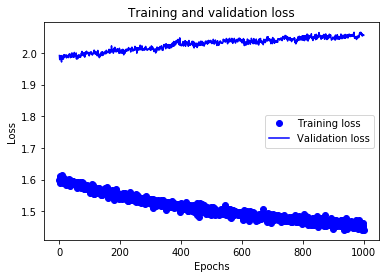

In [209]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



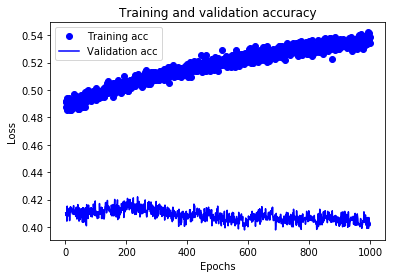

In [210]:
history_dict = history.history
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [211]:
model.load_weights(filepath)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3304/3304 [==============================] - 0s 66us/step
acc: 36.14%


              precision    recall  f1-score   support

           0       0.45      0.37      0.40       123
           1       0.29      0.31      0.30       131
           2       0.72      0.74      0.73       129
           3       0.28      0.27      0.27       130
           4       0.34      0.26      0.30       131
           5       0.24      0.20      0.22       128
           6       0.35      0.36      0.35       121
           7       0.51      0.46      0.48       123
           8       0.31      0.28      0.29       127
           9       0.19      0.09      0.13       127
          10       0.21      0.21      0.21       124
          11       0.26      0.39      0.31       121
          12       0.35      0.34      0.34       133
          13       0.20      0.27      0.23       124
          14       0.33      0.40      0.36       124
          15       0.34      0.38      0.36       127
          16       0.73      0.67      0.70       127
          17       0.63    

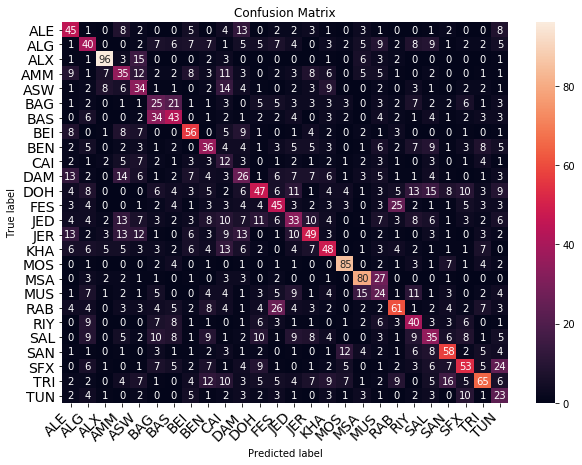

In [212]:
# and now we will prepare data for scikit-learn confusion matrix and classification report
Y_pred = model.predict_classes(X_test)
Y_pred = keras.utils.to_categorical(Y_pred, num_classes=len(LANGUAGES_DICT))
LABELS =  list(LANGUAGES_DICT.keys())
# Plot confusion matrix 
from sklearn.metrics import confusion_matrix,classification_report
from support import print_confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(Y_pred,axis=1), np.argmax(Y_test,axis=1))
_ = print_confusion_matrix(cnf_matrix, LABELS)
print(classification_report(np.argmax(Y_test,axis=1), np.argmax(Y_pred,axis=1)))


In [207]:
from ipywidgets import interact_manual
from ipywidgets import widgets
from support import clean_text


def get_prediction(TEXT):
    if len(TEXT) < MAX_LEN:
        print("Text has to be at least {} chars long, but it is {}/{}".format(MAX_LEN, len(TEXT), MAX_LEN))
        return(-1)
    # Data cleaning
    print(" it is {}/{}".format(len(TEXT), MAX_LEN))
    cleaned_text = clean_text(TEXT)
    
    # Get the MAX_LEN char
    input_row = get_input_row(cleaned_text, 0, MAX_LEN, alphabet)
    
    # Data preprocessing (Standardization)
    test_array = standard_scaler.transform([input_row])
    
    raw_score = model.predict(test_array)
    pred_idx= np.argmax(raw_score, axis=1)[0]
    score = raw_score[0][pred_idx]*100
    
    # Prediction
    prediction = LABELS[model.predict_classes(test_array)[0]]
    print('TEXT:', TEXT, '\nPREDICTION:', prediction.upper(), '\nSCORE:', score)


test_file = cleaned_directory_test
        
    
interact_manual(get_prediction, TEXT=widgets.Textarea(placeholder='ازيك عامل ايه انا سألت عنك كتير اوي'));

interactive(children=(Textarea(value='', description='TEXT', placeholder='ازيك عامل ايه انا سألت عنك كتير اوي'…

In [213]:
from ipywidgets import interact_manual
from ipywidgets import widgets
from support import clean_text


def get_prediction(TEXT,lang_code):
    if len(TEXT) < MAX_LEN:
        print("Text has to be at least {} chars long, but it is {}/{}".format(MAX_LEN, len(TEXT), MAX_LEN))
        return(-1)
    # Data cleaning
    print(" it is {}/{}".format(len(TEXT), MAX_LEN))
    cleaned_text = clean_text(TEXT)
    
    # Get the MAX_LEN char
    input_row = get_input_row(cleaned_text, 0, MAX_LEN, alphabet)
    
    # Data preprocessing (Standardization)
    test_array = standard_scaler.transform([input_row])
    
    raw_score = model.predict(test_array)
    pred_idx= np.argmax(raw_score, axis=1)[0]
    score = raw_score[0][pred_idx]*100
    
    # Prediction
    prediction = LABELS[model.predict_classes(test_array)[0]]
    #print('TEXT:', TEXT, '\nPREDICTION:', prediction.upper(), '\nSCORE:', score)
    print('\nPREDICTION:', prediction.upper(), '  Actual',lang_code, '\t SCORE:', score)
    if prediction.upper() == lang_code:
        return True
    else:
        return False



#test_file = cleaned_directory_test
        
    
#interact_manual(get_prediction, TEXT=widgets.Textarea(placeholder='ازيك عامل ايه انا سألت عنك كتير اوي'));



total = 0
for lang_code in LANGUAGES_DICT:
    Acc = 0
    start_index = 0
    path = os.path.join(cleaned_directory_test,lang_code+"_clean.txt")
    with open(path, 'r') as f:
            print ("Processing file : " + path)
            lines = f.readlines()
            content_length = len(''.join(lines))  
            print ("File size : ",size_mb(content_length))
            for file_content in lines:
                TEXT= file_content
                remaining = content_length - MAX_LEN*NUM_test
                jump = int(((remaining/NUM_test)*3)/4)

                #for idx in range(NUM_test):
                    #if (content_length-start_index < 400):
                        #break
                
                print(TEXT)
                while len(TEXT) < MAX_LEN+70:
                    TEXT += ' '+TEXT
                
                if get_prediction(TEXT,lang_code):
                    Acc += 1
                    
            local = Acc/len(lines)  
            print('Accuracy _ =',lang_code,' = ',local )
    total += local
print('Final Accuracy _  = ', total/5200)


        

Processing file : ../data/Dialect26/cleaned_test/ALE_clean.txt
File size :  0.01 MB
 بالمناسبة اسمي هيروشي إيجيما

 it is 247/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016482403225381859
 هاد القطار بوقف عند ليك فوريست ما ؟

 it is 303/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 هي البطاقة تمام ؟

 it is 319/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 ما طلع شي من الماكينة ؟

 it is 207/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 في شي خرج آخدو مشان هالطفح ؟

 it is 247/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 آيكيدا معك عندي حجز طاولة عالستة ونص المسا بس بعتذر بدي أتأخر نص ساعة

 it is 287/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 نمت لبعد منبه الستة ونص

 it is 207/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 عنا حوالي تلاتين نوع زيوت حمام

 it is 263/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 خرج حدا يدق يفيقني عالخمسة ونص


PREDICTION: CAI   Actual ALE 	 SCORE: 0.002622938518470619
 نبيذ تاني إذا سمحت

 it is 335/100

PREDICTION: MUS   Actual ALE 	 SCORE: 0.0009673505701357499
 قالوا إعلان الصعود وخلصوا ؟

 it is 239/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 خلينا نتفرج عالتلفزيون في مباراة بيسبول طالعة

 it is 191/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 كم ولاية في غير طوكيو ؟

 it is 207/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016404997950303368
 ما عندي مضارب ولا بواط

 it is 199/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016457130186608993
 مكتب الاستقبال كيف فيني أساعدك ؟

 it is 279/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 لازم تشتغل غالباً لوقت متأخر ؟

 it is 263/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458543541375548
 كتير آسف بس ما عنا كمان بصير ورق إنكليزي ؟

 it is 179/100

PREDICTION: JED   Actual ALE 	 SCORE: 0.0016458763639093377
 خرج تفرجيني شوية فساتين ؟

 it is 223/100

PREDICTION: JED   Actual 


PREDICTION: FES   Actual ALG 	 SCORE: 0.0007257744982780423
 واش نقدر نوريلك ؟

 it is 319/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0016458763639093377
 رقم الرحلة هو أش بي تسعة و ثمانون لطوكيو فالإحد عشر من مارس

 it is 247/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0010209460015175864
 اذا عندكم واحدأوخر ؟

 it is 183/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0010209391803073231
 سامحني نعاود نجي ممبعد

 it is 199/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0016458763639093377
 راني حاب كأس ماء باش نشرب الدوا من فضلك

 it is 335/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0016458763639093377
 واشنو هاذ الموسيقى ؟

 it is 183/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0010209479114564601
 راني حاب نحجز للرحلة تع الخطوط نورثويست رقم صفر ستة و ثمانون نهار خمسة

 it is 291/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0010209479114564601
 راني نفكر نتعلم نلعب الغولف

 it is 239/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0016458763639093377
 تقدر تعطيني كأس واحدوأخر

 it is


PREDICTION: JED   Actual ALG 	 SCORE: 0.0016458763639093377
 إيه نظن بلي راح نستنا

 it is 191/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0016458763639093377
 عندي الجهاز ديالي

 it is 319/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0016458763639093377
 البطاقة تع الغرفة ديالي معلباليش وشبيها تقدر تعطيني واحدوخرا من فضلك ؟

 it is 291/100

PREDICTION: FES   Actual ALG 	 SCORE: 0.0008263001291197725
 عندي احمرارات في ذراعتيا

 it is 215/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0010209479114564601
 نبيذ آخر من فضلك

 it is 303/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0010209479114564601
 اذا الإعلان للصعود جاز ؟

 it is 215/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0016403448171331547
 نشوفو التلفزيون راهي تجوز مباراة بيزبول

 it is 335/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0016458763639093377
 شحال كاين من محافظة من غير طوكيو ؟

 it is 295/100

PREDICTION: JED   Actual ALG 	 SCORE: 0.0016458763639093377
 ماعندي لا نوادي و لا أحذية

 it is 231/100

PREDICTION: JED  


PREDICTION: CAI   Actual ALX 	 SCORE: 0.0029233207897050306
 تلتمية وخمسين دولار ؟ دة فوق الميزانية بتاعتى

 it is 191/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016459249309264123
 أقدر أفرجك إيه ؟

 it is 303/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.001644244730414357
 رقم الرحلة اتش بى تسعة وتمانين لطوكيو فى حداشر مارس

 it is 215/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016458763639093377
 عندك واحد تانى ؟

 it is 303/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016458763639093377
 أنا أآسف أنا هرجع تانى بعدين

 it is 247/100

PREDICTION: CAI   Actual ALX 	 SCORE: 0.0010828159247466829
 عاوز كوباية ميا علشان أخد الدوا من فضلك

 it is 335/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016459971448057331
 إيه الموسيقى دى ؟

 it is 319/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016457224774057977
 عاوز اعمل حجز فى شركات طيران نورث ويست رحلة زيرو تمانية ستة ليوم خمسة

 it is 287/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0010256751920678653
 انا بخطط أتعلم الجولف

 it


PREDICTION: JED   Actual ALX 	 SCORE: 0.0016458763639093377
 التواليت مش شغال

 it is 303/100

PREDICTION: FES   Actual ALX 	 SCORE: 0.0005130346835358068
 من هنا لسيتي هول ياخد وقت أد إيه مشى ؟

 it is 327/100

PREDICTION: BEN   Actual ALX 	 SCORE: 0.0013652082088810857
 أوه فى حاجات كتير لازم تشوفها فى قرية غرينيتش

 it is 191/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016458763639093377
 هى دى مكونات طبيعية ؟

 it is 191/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016458763639093377
 هى دى جولة ليوم كامل ؟

 it is 199/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016443593267467804
 هى أوضتك بتطل على المدينة ؟

 it is 239/100

PREDICTION: BEN   Actual ALX 	 SCORE: 0.0016133270037244074
 هاخد كوباية نبيت

 it is 303/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016458763639093377
 عاوز أجرب نفس الطبق اللى زى دة

 it is 263/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016458763639093377
 جلد تمساح ؟

 it is 223/100

PREDICTION: JED   Actual ALX 	 SCORE: 0.0016458763639093377
 ل


PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 هاد بيجي معه سلطة مختارة واختيار من البطاطا المهروسة أو البطاطا مقلية

 it is 287/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 من وين بقدر أجيب أصيص ؟

 it is 207/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 راح آخد سندويشة هوت دوغ و ببسي

 it is 263/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 معك موظف المكالمات الخارجي

 it is 231/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 شو ؟ لازم تدفع ضريبة بس يكون عندك أكتر من تلت قناني كحول ؟

 it is 243/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 صاحبي كتير مريض ممكن تتصل بالدكتور لو سمحت ؟

 it is 187/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 ممكن تتصل في الصبح بكير لو سمحت ؟

 it is 287/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 في كازية على بعد شارعين من هون

 it is 263/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.00164587636390


PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 عندك أي غرف أكبر ؟

 it is 335/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 عبي نموذج التسجيل هاد لو سمحت

 it is 255/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0010209420906903688
 بدي مقعد منيح

 it is 255/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 إحكيها مرة تانية لو سمحت

 it is 215/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016459282051073387
 بيطلعوا تمنية وتلاتين دولار كلهم مع بعض

 it is 335/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
 خمسين جنيه

 it is 207/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0011377098417142406
 راح أراهن بتلاتة دولار على هاد

 it is 263/100

PREDICTION: JED   Actual AMM 	 SCORE: 0.0016458763639093377
Accuracy _ = AMM  =  0.0
Processing file : ../data/Dialect26/cleaned_test/ASW_clean.txt
File size :  0.01 MB
 بالمناسبة انا اسمي هيروشي ايجيما

 it is 279/100

PREDICTION: JED   Actual ASW 	 SCORE: 0.0016458763639093377
 ال


PREDICTION: BEN   Actual ASW 	 SCORE: 0.0016133486496983096
 ممكن تقول ده تانى ؟

 it is 175/100

PREDICTION: JED   Actual ASW 	 SCORE: 0.0016458763639093377
 لمؤاخذة كنت عايز استخدم الحمام

 it is 263/100

PREDICTION: JED   Actual ASW 	 SCORE: 0.0016455011063953862
 ملح لوسمحت

 it is 207/100

PREDICTION: JED   Actual ASW 	 SCORE: 0.0016458763639093377
 ممكن تفضيلى الطربيزة لو سمحت ؟

 it is 263/100

PREDICTION: JED   Actual ASW 	 SCORE: 0.0016458763639093377
 لوسمحت لفهم كل واحد لوحده

 it is 223/100

PREDICTION: JED   Actual ASW 	 SCORE: 0.0016458763639093377
 كده ماشى ممكن نستناك فين ؟

 it is 231/100

PREDICTION: JED   Actual ASW 	 SCORE: 0.0016458763639093377
 أقدر أركن عربيتى فين ؟

 it is 199/100

PREDICTION: MUS   Actual ASW 	 SCORE: 0.0030471206628135405
 أنا حاس نفسى بردان ومعدتى بتوجعنى جامد

 it is 327/100

PREDICTION: JED   Actual ASW 	 SCORE: 0.0016458763639093377
 أنا هروح أقعد مع واحد صاحبى

 it is 239/100

PREDICTION: JED   Actual ASW 	 SCORE: 0.0016431162293883972
 


PREDICTION: JED   Actual BAG 	 SCORE: 0.0010209479114564601
 اريد مصباح

 it is 207/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 اريد أوراق مال ملاحظات

 it is 199/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 احس صدري مقبط

 it is 255/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 قمة جبل فوجي اعلى قمم جبال اليابان توصل تلتالاف وسبع مية وستة وسبعين متر

 it is 299/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 أريد كريم ليلي

 it is 271/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 هل ايام اني دائما استعمل الحاسبة بالشغل

 it is 335/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 تلث مية وخمسين دولار ؟ هاي فوك امكانيتي

 it is 335/100

PREDICTION: DOH   Actual BAG 	 SCORE: 0.0008021382200240623
 شتريد أشوفك ؟

 it is 255/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016459578546346165
 رقم الرحة اتش بي تسعة وثمانين الى طوكيو اذار يوم دعش

 it is 219/100

PREDICTION: JE


PREDICTION: JED   Actual BAG 	 SCORE: 0.0010209479114564601
 واحد لاخ نبيذ رجاءً

 it is 175/100

PREDICTION: BAG   Actual BAG 	 SCORE: 0.0019324614186189137
 هل تم اعلان الصعود تم ؟

 it is 207/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 خلي نشوف التلفزيون اكو لعبة بايسبول

 it is 303/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 شكد عدد المحافظات الموجوده الى جانب طوكيو ؟

 it is 183/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 ماعندي اي نوادي او احذية

 it is 215/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0010209479114564601
 الاستعلامات شلون اكدر اساعدك ؟

 it is 263/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 هل انته معتاد تشتغل الى وقت متأخر ؟

 it is 303/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458967365906574
 كولش آسف بس بعد ما عدنا شنو رأيك باوراق انجليزية ؟

 it is 211/100

PREDICTION: JED   Actual BAG 	 SCORE: 0.0016458763639093377
 تكدر تشوفني بعض العناوين ؟

 it is 231/100

PRE


PREDICTION: JED   Actual BAS 	 SCORE: 0.0010209479114564601
 اكدر اعزمك على عشا فد مرة ؟

 it is 239/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 همه ولاشي

 it is 191/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 ما افهم امريكي انا احجي انكليزي بريطاني

 it is 335/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 لا هذول كلش اقوياء

 it is 335/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.00102064523161971
 من هذا الطريق رجاءا اصعد بهذا المصعد

 it is 311/100

PREDICTION: BAG   Actual BAS 	 SCORE: 0.005637667709379457
 راح تبدل هذا بواحد من نفس النوع رجاءا ؟

 it is 335/100

PREDICTION: BAG   Actual BAS 	 SCORE: 0.005535262607736513
 را اخذ اثنين من هذول

 it is 183/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0010209343599854037
 عندك فد فلم لسلايدات ملونة ؟

 it is 247/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 اكدر ادفع بصك سياحي ؟

 it is 191/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.001645876363909


PREDICTION: JED   Actual BAS 	 SCORE: 0.001018134116748115
 كلفة الغرفة ست الاف ين لليلة

 it is 247/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 حمام الاملاح العشبية يخلي جلدك يحس بنعومة

 it is 175/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 ماكو مشكلة

 it is 207/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 اعذرني شلون اوصل للبنك ؟

 it is 215/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0010209479114564601
 تكدر تأكد حجز الطيران ؟ هاي بطاقتي

 it is 295/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 اريد اممد وجودي هنا بعد يومين

 it is 255/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 انا اكعد المعة الصبح او الجمعة بعد الظهر

 it is 171/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 ما اكدر انام زين بالليل

 it is 207/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.0016458763639093377
 الشي الجنت ادور عليه

 it is 183/100

PREDICTION: JED   Actual BAS 	 SCORE: 0.


PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 اوك هيدا واضح إذا بتريد تنيناتكن عطوني دفاتر السواقة و التسجيل وانت يا ابني للاسف رح نعملك تحليل النفس

 it is 209/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 مي الدوا تبعي

 it is 255/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 هالباص بيوقف حد الأوتيل ؟

 it is 223/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 إذا بتريد قباض بتشك السفر

 it is 223/100

PREDICTION: MUS   Actual BEI 	 SCORE: 0.001186849931400502
 كتير مهم انو فينا نستعمل المواد الأولية لبدنا ياهن للمشروع

 it is 243/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 فيي اترك رسالة عمدق لأكد موعدي مع السيد ابرت الأربعا الجاي عالحداعش الصبح

 it is 303/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 فيك تشرح شوي مرضك بالانكليزي ؟

 it is 263/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 بوصل عالأوتيل لعندك حوالي التسعة المسا

 it is 327/100

PRED


PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 في نطرة شي عشر دئايئ

 it is 183/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016459987818961963
 أديش بتكلف الليموزين عوسط المدينة ؟

 it is 303/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458967365906574
 فيك تنزلي شنطتي عصالة الإستئبال بكرا الصبح ؟

 it is 187/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.001669293487793766
 إزا بتريد شو هيدا ؟

 it is 175/100

PREDICTION: CAI   Actual BEI 	 SCORE: 0.0025399365767952986
 تلاتين دولار وتمانين سنت

 it is 215/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 عندي موهبي خلئت معي

 it is 175/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 أي هوي أسرع التاكسي أو الإسعاف ؟

 it is 279/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458825484733097
 شو رأم الصندوء ؟

 it is 303/100

PREDICTION: JED   Actual BEI 	 SCORE: 0.0016458763639093377
 عندك أوضة أكبر ؟

 it is 303/100

PREDICTION: BEN   Actual BEI 	 SCORE: 0.0016128116840263829
 عبي


PREDICTION: JED   Actual BEN 	 SCORE: 0.0016458763639093377
 وريني وحدة أوسع

 it is 287/100

PREDICTION: JED   Actual BEN 	 SCORE: 0.0016458763639093377
 تبي اللفات الصغار و لا اللفات الكبار ؟

 it is 327/100

PREDICTION: JED   Actual BEN 	 SCORE: 0.0016458763639093377
 عندك دار فاضية الليلة ؟

 it is 207/100

PREDICTION: JED   Actual BEN 	 SCORE: 0.0016458763639093377
 ممكن تكلمني لو لقيت شنطتي ؟

 it is 239/100

PREDICTION: JED   Actual BEN 	 SCORE: 0.0016458763639093377
 لا تبي تبلغه ؟

 it is 271/100

PREDICTION: JED   Actual BEN 	 SCORE: 0.0016458763639093377
 اطلع من الباب هضكي غادي و راجي عند موقف رقم سته

 it is 199/100

PREDICTION: JED   Actual BEN 	 SCORE: 0.0016458763639093377
 دجاج محمر لو سمحت

 it is 319/100

PREDICTION: JED   Actual BEN 	 SCORE: 0.0016458763639093377
 أنا انجليزتي مش كويسة في أي يحكي ياباني هنا ؟

 it is 191/100

PREDICTION: JED   Actual BEN 	 SCORE: 0.0016458763639093377
 اها انضني حنراجي

 it is 303/100

PREDICTION: JED   Actual BEN 	 SCORE: 0.001645


PREDICTION: JED   Actual CAI 	 SCORE: 0.0010209479114564601
 عايز لمبة

 it is 191/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 عايز مفكرة

 it is 207/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 صدري طابق عليا

 it is 271/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 جبل فوجي أعلى قمة في اليابان على ارتفاع تلات تلاف و سبعميه و سته و سبعين متر

 it is 315/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 عايزة كريم مسائي

 it is 303/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 الايام ديه انا علطول بأستخدم الكمبيوتر في الشغل

 it is 199/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458230675198138
 تلتميه و خمسين دولار ؟ ده فوق ميزانيتي

 it is 327/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 ايه اللي اقدر اوريهولك ؟

 it is 215/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 رقم الرحلة اتش بي تسعة و تمانين رايحة اليابان في حداشر مارس

 it is 247/

PREDICTION: CAI   Actual CAI 	 SCORE: 0.0025405881387996487
 ممكن تأكد رحلتى تاني ؟ دى التذكرة بتاعتى

 it is 171/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0010211778317170683
 عايز أمد وجودي هنا يومين كمان

 it is 255/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 أنا فاتح الأربع الصبح أو الجمعة بعد الضهر

 it is 175/100

PREDICTION: BEN   Actual CAI 	 SCORE: 0.0016058163964771666
 مبقدرش أنام كويس بليل

 it is 191/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 الحاجة اللى كنت بدور عليها

 it is 231/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 ممكن أشتري مفرش تربيزة منين ؟

 it is 255/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016463503925479017
 كان فيه قد إيه ؟

 it is 303/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458730897284113
 المجلس حيبدأ أربعة ونص عشان كدة من فضلك كون موجود قلبك كدة

 it is 243/100

PREDICTION: JED   Actual CAI 	 SCORE: 0.0016458763639093377
 أنا بخطط إني أقعد اتناشر يوم

 it is 247/100

P


PREDICTION: JED   Actual DAM 	 SCORE: 0.0016458763639093377
 كتير مهم إننا نوصل للمواد الخام الازمة للمشروع

 it is 195/100

PREDICTION: CAI   Actual DAM 	 SCORE: 0.0025512685169815086
 ممكن اترك رسالة ؟ اتصلت لثبت موعدي مع الاستاذ إبريت الأربعة الجاية عالساعة إدعش الصبح

 it is 175/100

PREDICTION: JED   Actual DAM 	 SCORE: 0.001238593176822178
 فيك تحاول تشرح مرضك بالانجليزي ؟

 it is 279/100

PREDICTION: JED   Actual DAM 	 SCORE: 0.0016458763639093377
 رح أوصل عالأوتيل تبعك عالتسعة المسا تقريباً

 it is 183/100

PREDICTION: JED   Actual DAM 	 SCORE: 0.0016458763639093377
 بتفضل طاولة بالمطعم الرئيسي ولا بغرفة خاصة استاذ ؟

 it is 211/100

PREDICTION: JED   Actual DAM 	 SCORE: 0.001019426326820394
 في ناس انصابوا

 it is 271/100

PREDICTION: JED   Actual DAM 	 SCORE: 0.0016458763639093377
 لو سمحت وين المحطة القريبة من هون ؟

 it is 303/100

PREDICTION: JED   Actual DAM 	 SCORE: 0.0016458763639093377
 عندي أختين

 it is 207/100

PREDICTION: JED   Actual DAM 	 SCORE: 0.00164587636390


PREDICTION: SAN   Actual DOH 	 SCORE: 0.0009247823072655592
 تبدل هذي مع واحد من نفس النوع لو سمحت ؟

 it is 335/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0010209479114564601
 باخذ اثنين من هذي

 it is 319/100

PREDICTION: FES   Actual DOH 	 SCORE: 0.0007141035439417465
 عندك فلم حق صور ملونة ؟

 it is 207/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 ممكن ادفع بجيك سياحي ؟

 it is 199/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 بغيت خريطة سان فرانسيسكو والمنطقة حوالينها

 it is 179/100

PREDICTION: FES   Actual DOH 	 SCORE: 0.0005074596629128791
 ممكن احجز غرفة دبل تطل على المحيط ؟

 it is 303/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 في أي جهة من يونيون سكوير هو ؟

 it is 263/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 ابغي نفس الدورة بكرة لو سمحت

 it is 247/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.00164586217579199
 اسمح لي بس انا ضيعت الطريق ممكن تساعدني ؟

 it is 175/100

PREDICTION: J

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 لو سمحت لا تعطي احد غيري هالمفتاح

 it is 287/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 فيني سخونة من امس في الليل

 it is 231/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 ممكن توصل شناطي للغرفة ؟

 it is 215/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016455671357107349
 عندك شي بثمانين دولار بالضبط ؟

 it is 263/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0010209410902461968
 عندي ثلاث شناط

 it is 271/100

PREDICTION: FES   Actual DOH 	 SCORE: 0.00042569072320475243
 انا بعد

 it is 319/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 ممكن احول الحلق هذا لكليبسات ؟

 it is 263/100

PREDICTION: SAL   Actual DOH 	 SCORE: 0.0009648730156186502
 ما قررت للحين ممكن تعطيني وقت زيادة ؟

 it is 319/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 تشرب قهوة معاي ؟

 it is 303/100

PREDICTION: JED   Actual DOH 	 SCORE: 0.0016458763639093377
 عندك هذي ب


PREDICTION: DOH   Actual FES 	 SCORE: 0.0012080234228051268
 كنخطط نتعلم الغولف

 it is 335/100

PREDICTION: FES   Actual FES 	 SCORE: 0.0005074548425909597
 عافاك عطيني مشروب أخور

 it is 199/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 واش عند كبر منو ؟

 it is 319/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 واش كتعرف الجغرافيا ديال اليابان ؟

 it is 295/100

PREDICTION: FES   Actual FES 	 SCORE: 0.0005083014912088402
 بغيت الشريط ديال الآلة الكاتبة

 it is 263/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 عبر القنطرة للجهة الاخرى وغادي تلقى المكتبة على يديك ديال اليسار

 it is 267/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 عافاك عاوني نلقى شي مرشد كيتكلم اليابانية

 it is 175/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 غادي نكون تما فداك الستة ديال الليل

 it is 303/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 واش هاد المتجر غادي يكون مفتوح غدا ؟

 it is 


PREDICTION: JED   Actual FES 	 SCORE: 0.001585678728588391
 كان الشارع مزداحم بالسيارات

 it is 239/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 أنا أتفق هادي من بين البلايص المفضلة عندي

 it is 175/100

PREDICTION: BEN   Actual FES 	 SCORE: 0.0016133270037244074
 غادي نتشاركو

 it is 239/100

PREDICTION: FES   Actual FES 	 SCORE: 0.0005074548425909597
 فين ممكن نمشي نشوف منظر زوين ؟

 it is 263/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 واش هادا طران مباشر ؟

 it is 191/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 بغيت نطلب عافاك

 it is 287/100

PREDICTION: FES   Actual FES 	 SCORE: 0.0005074548425909597
 السيارة كتدير صداع غريب

 it is 207/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 راه دفعت من قبل عربون خمسين دولار ملي دخلت

 it is 179/100

PREDICTION: JED   Actual FES 	 SCORE: 0.0016458763639093377
 بغيتك تديني لشي بلايص مثيرة أنا سائح كتعرف

 it is 179/100

PREDICTION: FES   Actual FES 	 SCORE


PREDICTION: JED   Actual JED 	 SCORE: 0.0016458763639093377
 دجاج مشوي لو سمحت

 it is 319/100

PREDICTION: JED   Actual JED 	 SCORE: 0.0016450963812530972
 انا مو كويس بالإنجليزي فيه احد هنا يتكلم يأباني ؟

 it is 207/100

PREDICTION: CAI   Actual JED 	 SCORE: 0.0025552595616318285
 أيوا أتوقع اني حنتظر

 it is 183/100

PREDICTION: JED   Actual JED 	 SCORE: 0.0016458763639093377
 عندي أدواتي

 it is 223/100

PREDICTION: JED   Actual JED 	 SCORE: 0.0016458780009998009
 فيه مشكلة مع البطاقة دي ممكن تبدلي هو بواحد تاني لو سمحت ؟

 it is 243/100

PREDICTION: JED   Actual JED 	 SCORE: 0.0016458763639093377
 عندي طفح جلدي بيديني

 it is 183/100

PREDICTION: JED   Actual JED 	 SCORE: 0.0016458763639093377
 نبيذ تاني لو سمحت

 it is 319/100

PREDICTION: JED   Actual JED 	 SCORE: 0.0010209479114564601
 اعلنو عن الصعود ؟

 it is 319/100

PREDICTION: JED   Actual JED 	 SCORE: 0.0016458763639093377
 خلينا نتابع التلفزون فيه مباراة بيسبول

 it is 327/100

PREDICTION: JED   Actual JED 	 SCORE: 0.0


PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 ما بفهم أمريكي أنا بحكي انجليزي بريطاني

 it is 335/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 لا هدول كتير ثابتين

 it is 175/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0010209470019617584
 من هون لو سمحت اطلع بالاصانصير

 it is 263/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 بتقدر تبدلي هدا بواحد تاني من نفس النوع لو سمحت ؟

 it is 207/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 رح أخد تنتين من هدول

 it is 183/100

PREDICTION: JED   Actual JER 	 SCORE: 0.001645699012442492
 في عندك فيلم لصور ملونة ؟

 it is 223/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 بقدر أدفع بشيك سياحي ؟

 it is 199/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 بدي خريطة سان فرانسيسكو و المنطقة حواليها

 it is 175/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 بقدر أحجز غرفة مزدوجة بتطل على المحيط ؟

 it is 335/100

PREDI


PREDICTION: JED   Actual JER 	 SCORE: 0.0016456566299893893
 مم هدا هدا اللون لابق عليك

 it is 231/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 غير قانوني اتجيبو على البلد متأسف طيب بتوقع هدا كل اشي

 it is 227/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 رسوم الغرفة ستة آلاف ين في الليلة

 it is 287/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 حمام الأعشاب و الملح بيخلي جلدك يصير ناعم و سلس

 it is 199/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 مش مشكلة

 it is 175/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 لو سمحت كيف بقدر أوصل للبنك ؟

 it is 255/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 بتقدر تأكدلي على طيارتي ؟ هي تزكرة الطيران

 it is 179/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 بدي أمدد قعدتي هون كمان يومين

 it is 255/100

PREDICTION: JED   Actual JER 	 SCORE: 0.0016458763639093377
 أنا بفتح من الأربعا الصبح للجمعة المسا

 حاسي بضيق في الصدر

 it is 335/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016453350326628424
 جبل فوجي هو أعلى قمة يابانية عند تلاتة ألف و سبعمائة ستة وسبعين متر

 it is 279/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458763639093377
 داير بعض كريم الليل

 it is 175/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458323443657719
 هذه الايام دائما بستخدم كمبيوتر في الشغل

 it is 171/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0010165003004658502
 تلتمية و خمسين دولار ؟ داك فوق ميزانيتي

 it is 335/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458763639093377
 ممكن أوريك شنو ؟

 it is 303/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458763639093377
 رقم الرحلة اتش بي تسعة وتمانين لتوكيو في الحادي عشر من مارس

 it is 247/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458763639093377
 هل عندك واحد تاني ؟

 it is 175/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458763639093377
 انا اسف ح اجي راجع لاحقا

 it is 215/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.00164585


PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458794561913237
 داير أطلب من فضلك

 it is 319/100

PREDICTION: BEN   Actual KHA 	 SCORE: 0.0016133270037244074
 العربية بتعمل ازعاج غريب

 it is 215/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458763639093377
 أنا بالفعل دفعت عربون خمسين دولار لما دخلت

 it is 179/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458763639093377
 دايرك تاخدني لبعض الأماكن المثيرة انا سائح انت عارف

 it is 215/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.001020949912344804
 هناك ح يكون في عشرة دقائق إنتظار ول كدا

 it is 335/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016460096958326176
 كم بتكلف الليموزين عشان تمشي لمركز المدينة ؟

 it is 187/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458763639093377
 ممكن تجيب عفشي تحت اللوبي صباح بكرة ؟

 it is 319/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0016458763639093377
 دا شنو من فضلك ؟

 it is 303/100

PREDICTION: JED   Actual KHA 	 SCORE: 0.0015675954273319803
 تلاتين دولار تمنين

 it is 335/100

P

PREDICTION: JED   Actual MOS 	 SCORE: 0.0016458763639093377
 خلونه نشوف تلفزيون اكو مباراة كره سله عتنعرض

 it is 187/100

PREDICTION: JED   Actual MOS 	 SCORE: 0.0016458763639093377
 كم محافظه اكو بجانب طوكيو ؟

 it is 239/100

PREDICTION: JED   Actual MOS 	 SCORE: 0.0016458763639093377
 ما عندي اي نوادي او احذيه

 it is 223/100

PREDICTION: JED   Actual MOS 	 SCORE: 0.0010209479114564601
 مكتب الاستقبال هل ممكن اساعدك ؟

 it is 271/100

PREDICTION: JED   Actual MOS 	 SCORE: 0.0016458763639093377
 هل عاده لازم تعمل لوقت متاخر ؟

 it is 263/100

PREDICTION: JED   Actual MOS 	 SCORE: 0.0016458763639093377
 كلش اسف بس ما عدنه بعد اشنو رايكم بفلفل انكليزي ؟

 it is 207/100

PREDICTION: JED   Actual MOS 	 SCORE: 0.0016458763639093377
 اتطيق تشوفني شوية فسيتين ؟

 it is 231/100

PREDICTION: JED   Actual MOS 	 SCORE: 0.0016458763639093377
 ممكن تستظيفني الليلي ؟

 it is 199/100

PREDICTION: JED   Actual MOS 	 SCORE: 0.0016458763639093377
 ماشي هسا خلينه نلقي نضره عليك

 it is 255/100

PREDIC

PREDICTION: JED   Actual MSA 	 SCORE: 0.0016452282579848543
 لقد طلبته منذ وقت طويل

 it is 199/100

PREDICTION: JED   Actual MSA 	 SCORE: 0.0010207766536041163
 من فضلك هل لك أن ترسل بواباً إلى غرفتي في السادسة صباحاً ؟

 it is 243/100

PREDICTION: CAI   Actual MSA 	 SCORE: 0.0024836404918460175
 شكراً مرحباً شكراً لانتظارك

 it is 239/100

PREDICTION: JED   Actual MSA 	 SCORE: 0.0016458763639093377
 نحن هنا لمدة يوم

 it is 303/100

PREDICTION: JED   Actual MSA 	 SCORE: 0.0016458763639093377
 ما هو الحد الأدنى للعمر لفعل ذلك ؟

 it is 295/100

PREDICTION: JED   Actual MSA 	 SCORE: 0.0010209479114564601
 إنّ الإحصاء كرة واحدة وضربتين

 it is 255/100

PREDICTION: JED   Actual MSA 	 SCORE: 0.0016593545296927914
 اسمي كيمورا أريد إلغاء حجزي الخاص بيوم الجمعة

 it is 191/100

PREDICTION: JED   Actual MSA 	 SCORE: 0.001647120006964542
 تُرى هل ثمة مائدة متاحة بالقرب من النافذة لسبعة أشخاص الليلة

 it is 251/100

PREDICTION: SAL   Actual MSA 	 SCORE: 0.0011777352483477443
 هل يمكن أن تدلّني

PREDICTION: JED   Actual MUS 	 SCORE: 0.0010060730346594937
 هل بتشل شنطتي حتى الساعة الثالثة ؟

 it is 295/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.001020948911900632
 هل اقدر احجز اجر سيارة اهني ؟

 it is 255/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0016378064174205065
 هل نسيت مشروباتنا ؟

 it is 175/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0016458763639093377
 عندنا البيرة ويسكي براندي الجن الفودكا والنبيذ

 it is 195/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0010209479114564601
 بجم الى مانشستر ؟

 it is 319/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0010210063919657841
 اهني الرقم

 it is 207/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0016458763639093377
 يمكن بس افضل لو نوزن كل وحده بروحها

 it is 303/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0016458763639093377
 هل هالباص يروح لفندق هيلتون ؟

 it is 255/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0016458763639093377
 اقدر اعزمكم على العشا لبعض الوقت ؟

 it is 295/100

PREDICTION: JED   Actual MUS 	 SCORE:


PREDICTION: BEN   Actual MUS 	 SCORE: 0.0016119000065373257
 آسف جدا ولكن ماعندي أكثر من ذلك كيف عن الأوراق الإنجليزية ؟

 it is 247/100

PREDICTION: MUS   Actual MUS 	 SCORE: 0.0009979506103263702
 تقدر تظهر لي بعض الفساتين ؟

 it is 239/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0016458763639093377
 بتستضيفني الليلة ؟

 it is 335/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0016458763639093377
 حسنا الحين خلونا نشوفه

 it is 199/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0016458763639093377
 انها خارج النظام هل يمكن أن تحق الكاميرا ؟

 it is 179/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0016458763639093377
 المرحاض ما يشفط

 it is 287/100

PREDICTION: BEN   Actual MUS 	 SCORE: 0.001319258262810763
 كم من الوقت يبغاله من هنا إلى سيتي هول مشي على الأقدام ؟

 it is 235/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0014948285752325319
 أوه هناك الكثير من الأشياء التي يجب أن تشوف في قرية غرينتش

 it is 243/100

PREDICTION: JED   Actual MUS 	 SCORE: 0.0010209479114564601
 هل هذه الم


PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 ما قدرتش نقاد الصورة

 it is 183/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 لا بغيت نكري نص مجموعة ديال مضارب و صباط

 it is 171/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 فين كاينة شي بلاصة للسياحة ؟

 it is 247/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 معلوم واش خاصك بيرمانونت ؟

 it is 231/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 غالي ياك ؟

 it is 207/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016120706277433783
 ممكن تخلي عندك الأمتعة ديالي حتال التلاتة ديال العشية ؟

 it is 231/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 واش نقدر نحجز اكري طوموبيل هنايا ؟

 it is 295/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 واش نسيتي المشروبات ديالنا ؟

 it is 247/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 عندنا البيرة الويسكي البراندي الدجين الڤودكا و النبيذ

 it is 223


PREDICTION: FES   Actual RAB 	 SCORE: 0.0005119740762893343
 كاينين جرحى

 it is 223/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.001644705844228156
 اسمح ليا فينا هي المحطة ؟

 it is 223/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 عندي جوج اخواتات

 it is 303/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 رقم الرحلة جوج زيرو تمنية لطوكيو

 it is 279/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 يمكن ليك حجز الأحداث ؟

 it is 199/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0010209479114564601
 بغيت سترة رياضية

 it is 303/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 تقدر تبقى فداري

 it is 287/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 آلة الفيديو تسرقات من الغرفة ديالي

 it is 295/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 واس يمكن ليك تعاود مرة اخرى ؟

 it is 255/100

PREDICTION: JED   Actual RAB 	 SCORE: 0.0016458763639093377
 اسمح لي بغيت نمشي للمرحاض

 


PREDICTION: JED   Actual RIY 	 SCORE: 0.0016458763639093377
 نسيت مشروباتنا ؟

 it is 303/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0016458763639093377
 عندنا بيرة ويسكي براندي جن فودكا و نبيذ

 it is 335/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0010209479114564601
 كم الأجرة الى مانشستر ؟

 it is 207/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0016458763639093377
 هذا الرقم

 it is 191/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0010209372703684494
 ربما لكن لازم نوزنهم بشكل منفصل

 it is 271/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0016458763639093377
 هل هذا الباص يروح لفندق هيلتون ؟

 it is 279/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0010209470019617584
 اقدر اعزمك على عشاء في وقت ما ؟

 it is 271/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.00164586217579199
 لا يوجد منها

 it is 239/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0016458763639093377
 ما افهم اللهجة الامريكية أتكلم بالانجليزي البريطاني

 it is 215/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.001645


PREDICTION: JED   Actual RIY 	 SCORE: 0.0010209479114564601
 عندي اختين

 it is 207/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0016458763639093377
 رحلة رقم اثنين صفر ثمانية الى طوكيو

 it is 303/100

PREDICTION: SAL   Actual RIY 	 SCORE: 0.0010169735105591826
 تقجر تحجز ملتقيات ؟

 it is 175/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0016449488612124696
 ابغى معطف رياضي

 it is 287/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0017454953194828704
 تقدر تقيم بمنزلي

 it is 303/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0016458763639093377
 مسجل الفيديو هذا انسرق من غرفتي

 it is 271/100

PREDICTION: FES   Actual RIY 	 SCORE: 0.00041930970837711357
 تقدر تقول ذاك مرة ثانية ؟

 it is 223/100

PREDICTION: SAL   Actual RIY 	 SCORE: 0.001035018703987589
 اعذرني ابغى استخدم الحمام

 it is 223/100

PREDICTION: FES   Actual RIY 	 SCORE: 0.00041794992284849286
 ملح لو سمحت

 it is 223/100

PREDICTION: JED   Actual RIY 	 SCORE: 0.0016458763639093377
 تقدر تنظف الطاولة لي لو سمحت ؟

 it is 


PREDICTION: BAG   Actual SAL 	 SCORE: 0.0011051794899685774
 وين في مكان منيح للسياحة ؟

 it is 231/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 أكيد بدك كيرلي ؟

 it is 303/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 غالي صح ؟

 it is 191/100

PREDICTION: FES   Actual SAL 	 SCORE: 0.0005437609161162982
 بتقدر تمسك أغراضي لحد الساعة ثلاثة ؟

 it is 311/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0009692509593151044
 بقدر أحجز أجر سيارة هون ؟

 it is 223/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 نسيت مشروباتنا ؟

 it is 303/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 عنا البيرة ويسكي براندي الجن الفودكا والنبيذ

 it is 187/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0010209479114564601
 شو الاجرة لمانشستر ؟

 it is 183/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 هي الرقم

 it is 175/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 يمكن بس لازم نوزنهم منفصلين


PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 ما في مشكلة

 it is 223/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 لو سمحت كيف اروح للبنك ؟

 it is 215/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 بتقدر تأكيد طلبي ؟ وهي تذكرة طيران

 it is 295/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.001020607214741176
 بدي امدد إقامتي هنا لمدة يومين أطول

 it is 303/100

PREDICTION: CAI   Actual SAL 	 SCORE: 0.00265716589638032
 انا بفتح الاربعاء الصبح او الجمعة العصر

 it is 335/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 ما بقدر انام منيح بالليل

 it is 215/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 الاشي اللي كنت بدور عليه

 it is 215/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 من وين بقدر اشتري طاولة لبس ؟

 it is 255/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.0016458763639093377
 قديش كان فيه ؟

 it is 271/100

PREDICTION: JED   Actual SAL 	 SCORE: 0.00164587636390933


PREDICTION: JED   Actual SAN 	 SCORE: 0.0016467540262965485
 ممكن بأي طريقه تشرح مرضك بالأنجليزي ؟

 it is 319/100

PREDICTION: JED   Actual SAN 	 SCORE: 0.0016451733245048672
 شوصل لحقك الفندق على تسع في الليل

 it is 287/100

PREDICTION: JED   Actual SAN 	 SCORE: 0.0016458763639093377
 تشتي ماسه في المطعم الرئيسي أو في الغرفه الخاصه سيدي ؟

 it is 227/100

PREDICTION: JED   Actual SAN 	 SCORE: 0.0016458763639093377
 به ناس جرحى

 it is 223/100

PREDICTION: JED   Actual SAN 	 SCORE: 0.0010209732863586396
 عفوا أين المحطه الذي هانا ؟

 it is 239/100

PREDICTION: SAN   Actual SAN 	 SCORE: 0.0006767204922653036
 معي ثنتين خوات

 it is 271/100

PREDICTION: FES   Actual SAN 	 SCORE: 0.0004179810275672935
 رقم الرحلة اثنين صفر ثمانيه ل طوكيو

 it is 303/100

PREDICTION: JED   Actual SAN 	 SCORE: 0.0010209450010734145
 ممكن تحجز للاحداث ؟

 it is 175/100

PREDICTION: JED   Actual SAN 	 SCORE: 0.0010209275387751404
 اشتي جاكت رياضي

 it is 287/100

PREDICTION: JED   Actual SAN 	 SCORE: 0.001

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 نحب اوراق جوابات

 it is 303/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 عندي احساس بوجيعة في صدري

 it is 223/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 جبل فوجي يتميز في اليابان بثلاثة الاف و سبع مية و ستة و سبعين ميترو

 it is 279/100

PREDICTION: FES   Actual SFX 	 SCORE: 0.0006454697086155647
 نحب كريمة الليل

 it is 287/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 في الوقت هذا نستعمل ديما كمبيوتر في الخدمة

 it is 179/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0010209479114564601
 ثلاثمية و خمسين دولار راهو فوق الي عندي

 it is 335/100

PREDICTION: FES   Actual SFX 	 SCORE: 0.00041792600313783623
 شنوة انجم نوريك ؟

 it is 319/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 نومرو الرحلة هو اتش بي تسع و ثمانين لطوكيو نهار احداش مارس

 it is 243/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0010209479114564601
 عندك واحد آخر ؟

 it is 287


PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 ايه ضاهرلي باش نقعد نستنى

 it is 223/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016445646906504408
 عندي حوايجي

 it is 223/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 فمة حاجة الي ماتمشيش في كارطة بيتي تنجم تعطيني وحدة اخرى يعيشك ؟

 it is 267/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 عندي حساسية فوق يدية

 it is 183/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 شراب وحداخر من فضلك

 it is 175/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 عيطوا للطلوع ؟

 it is 271/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 اغزر التلفزة يعديو في ماتش البيسبول

 it is 303/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016461635823361576
 قداش فما من ولاية بخلاف طوكيو ؟

 it is 271/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.0016458763639093377
 ما عندي لا اندية و لا احذية

 it is 239/100

PREDICTION: JED   Actual SFX 	 SCORE: 0.00


PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 نبي شوية كريمه متاع الليل

 it is 223/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 الايامات هادي ديمه نستخدم في كمبيوتر في الخدمه

 it is 195/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 تلتميه و خمسين دولار ؟ هدا فوق الميزانيه متاعي

 it is 195/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 شن نقدر نوريك ؟

 it is 287/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 رقم الرحله اتش بي تسعة و تمانين لطوكيو يوم حداش مارس

 it is 219/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 عندك واحد تاني ؟

 it is 303/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 اني اسف حنجي بعدين

 it is 335/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 نبي طاسة اميه باش ناخد شوية أدويه من فضلك

 it is 175/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016351876183762215
 شن الموسيقى هادي ؟

 it is 335/100

PREDICTION:


PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 وين نقدر نمشي باش نشوف منظر حلو ؟

 it is 287/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 هل هو قطار مباشر ؟

 it is 335/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 نبي نطلب لو سمحت

 it is 303/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 السياره اتدير في صوت غريب

 it is 223/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 اني دفعت من قبل ضمان خمسين دولار اول ما خشيت

 it is 187/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 نبيك ترفعني مكان مليح اني سائح زي ما تعرف

 it is 175/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 حيكون في عشره دقايق انتظار او حاجه هكي

 it is 327/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 قداش تكلف الليموزين لوسط البلد ؟

 it is 279/100

PREDICTION: JED   Actual TRI 	 SCORE: 0.0016458763639093377
 تقدر تنزل الشناطي متاعي للصاله الاستقبال غدوه الصبح ؟

 it 


PREDICTION: JED   Actual TUN 	 SCORE: 0.0016458763639093377
 إستقبال نجم نعاونك ؟

 it is 183/100

PREDICTION: JED   Actual TUN 	 SCORE: 0.0016458763639093377
 لزمك تخدم مخر ؟

 it is 287/100

PREDICTION: JED   Actual TUN 	 SCORE: 0.0016458763639093377
 اسفة إما معناش أكثر شعملت في أوراق لنجلاي ؟

 it is 183/100

PREDICTION: MUS   Actual TUN 	 SCORE: 0.0011783857189584523
 تنجم تورني شوية روب ؟

 it is 191/100

PREDICTION: JED   Actual TUN 	 SCORE: 0.0016458763639093377
 بش تسكني ليلة ؟

 it is 287/100

PREDICTION: JED   Actual TUN 	 SCORE: 0.0016458763639093377
 وتوا تراه نخزرلك

 it is 303/100

PREDICTION: JED   Actual TUN 	 SCORE: 0.0016458763639093377
 راهي ما تخدمش تنجمش تتفقد الكاميرا متاعي ؟

 it is 179/100

PREDICTION: JED   Actual TUN 	 SCORE: 0.0016458763639093377
 شاص توالت مكسر

 it is 271/100

PREDICTION: JED   Actual TUN 	 SCORE: 0.0016458763639093377
 قداش يلزم وقت من هوني لسيتي هول على سقينا ؟

 it is 183/100

PREDICTION: JED   Actual TUN 	 SCORE: 0.0016458763639093377